# Cyber Data Analytics Assignment 1
## Credit Card Fraud Detection
* Visualization task
* Imbalance task
* Classification task
* Bonus task

### Step 0: preprocessing & cleaning 
First things first, we need to load the raw data and do some basic preprocessing and cleaning.

In [1]:
import datetime
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
# read in the data, make sure that the csv file is in the same folder of this notebook.
src = 'data_for_student_case.csv'
df = pd.read_csv(src)
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


Some cleaning tasks are done here:
* Since "refused" transactions are ambiguous, we drop them here.
* Transform 'creationdate' to the time format which pandas can read
* assign labels
* other cleaning

In [3]:
# drop 'refused' transactions
cleaned_df = df.copy()
cleaned_df = cleaned_df[df['simple_journal']!='Refused']

In [4]:
# Transform 'creationdate' to the time format which pandas can read
cleaned_df['creation_date'] = pd.to_datetime(cleaned_df['creationdate'],format='%Y-%m-%d %H:%M:%S')
cleaned_df['creation_month'] = cleaned_df.creation_date.dt.month
cleaned_df['creation_weekday'] = cleaned_df.creation_date.dt.weekday
cleaned_df['creation_day'] = cleaned_df.creation_date.dt.date

In [5]:
# Calculate converted amount of money
def convert_currency(row):
    coversion_dict = {'SEK':0.08766,'MXN':0.04057,'AUD':0.5715,'NZD':0.5327,'GBP':1}
    currency = row['currencycode']
    amount = row['amount']
    return round(amount * coversion_dict[currency] / 100)

cleaned_df['converted_amount'] = cleaned_df.apply(lambda x: convert_currency(x),axis=1)

In [6]:
# assign labels: 1 for fraud, 0 for normal
cleaned_df['label'] = cleaned_df['simple_journal'].apply(lambda x: x=='Chargeback')

In [7]:
# some cleaning for cvc response
cleaned_df['cvcresponsecode'] = cleaned_df['cvcresponsecode'].apply(lambda x: (x>2) * 3 + (x<=2)*x) 

### Step1: visualization  task
* Visualizing the distribution of the converted amount of money.

In the previous step, we conveted all currencies to GBP.  In below, we draw a histogram and fit a kernel density estimate. Comparing the fraudulent from the benign, we can find that benign transactions are more densely distributed around 100 GBP, while fraud transactions are more likey to be greater numbers.

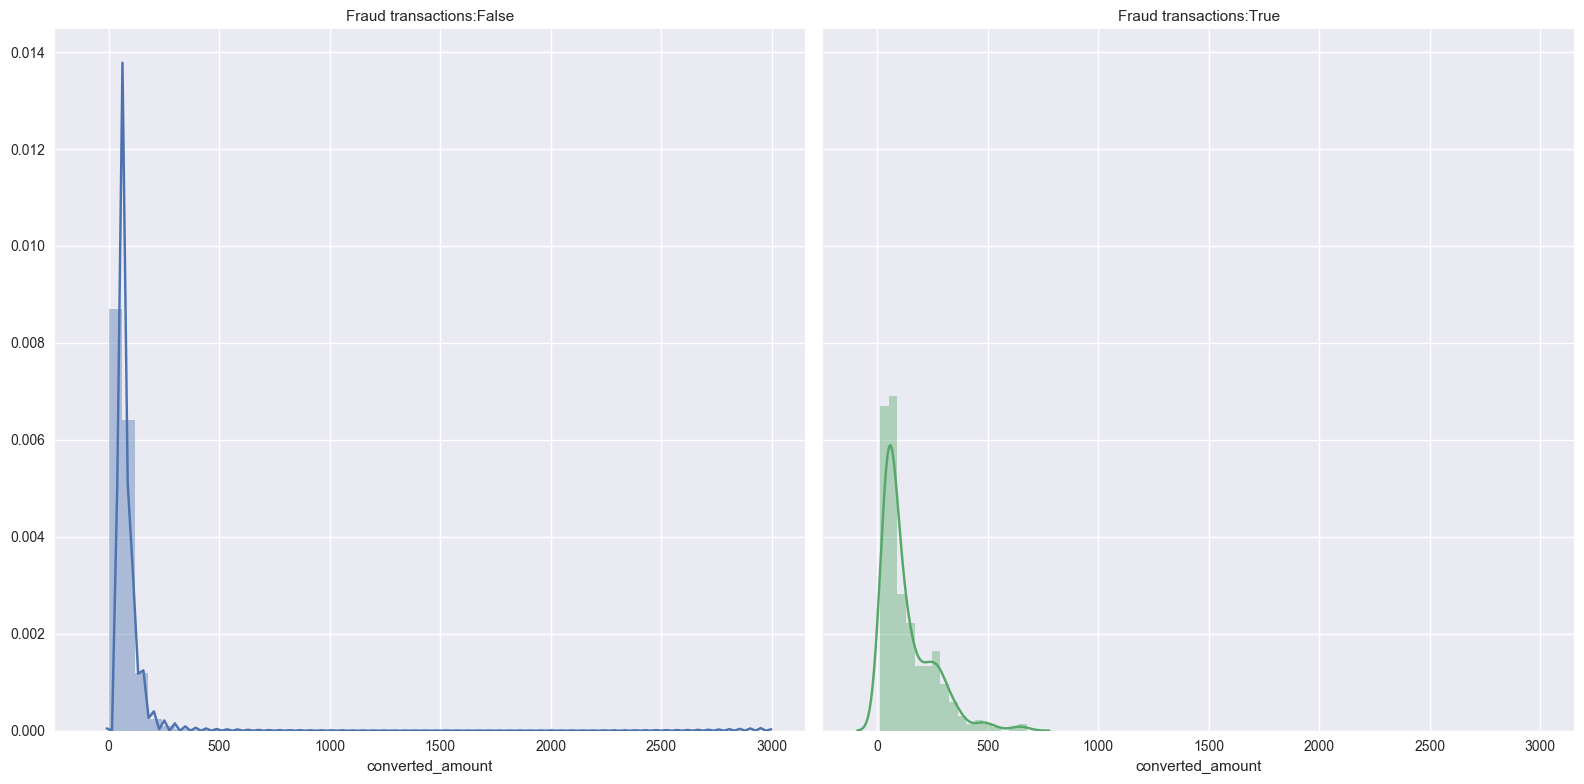

In [71]:
import seaborn as sns
g = sns.FacetGrid(cleaned_df, col="label", size=8,hue='label')
g.map(sns.distplot,"converted_amount",kde=True)
g.set_titles('Fraud transactions:{col_name}')

* Visualizing the categotical variables: currencycode and shopper interaction. From the picture below, we can find that most of the fraud transactions happened in Ecommerce (online transaction). only few of them appeared in ContAuth(subscribtion)and no fraud transactions appeared in POS. Apart from that, we got that majority of Ecommerce fraud transactions happened in SEK and MXN. In other word, there is a significant difference in fraud occurance among different currencycodes. It implies that currencycode and shopper interaction can be used as informative features for the following work.

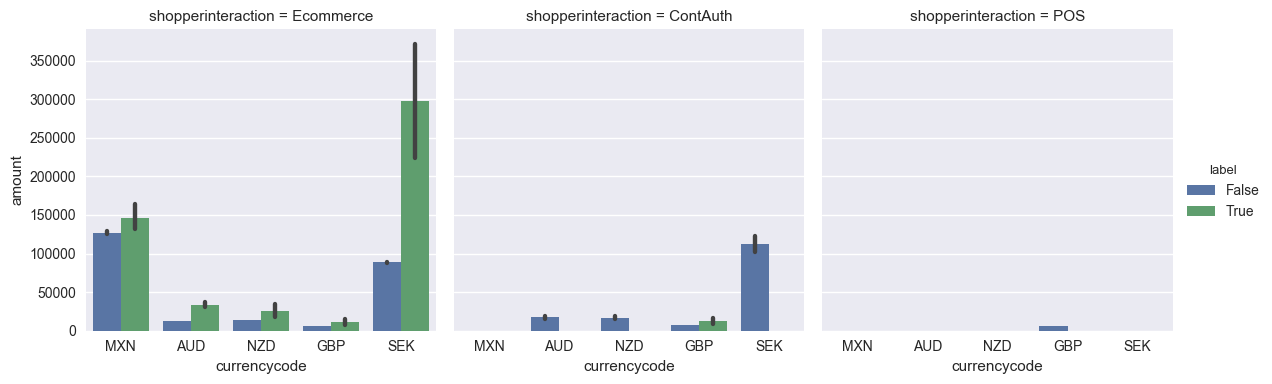

In [82]:
sns.factorplot(data=cleaned_df,x="currencycode", y="amount", hue="label",kind='bar',col='shopperinteraction')

* As shown in the boxplot below, it is noteworthy that different currencycodes have similar distributions of benign transactions but various distribution of fraud transaction.

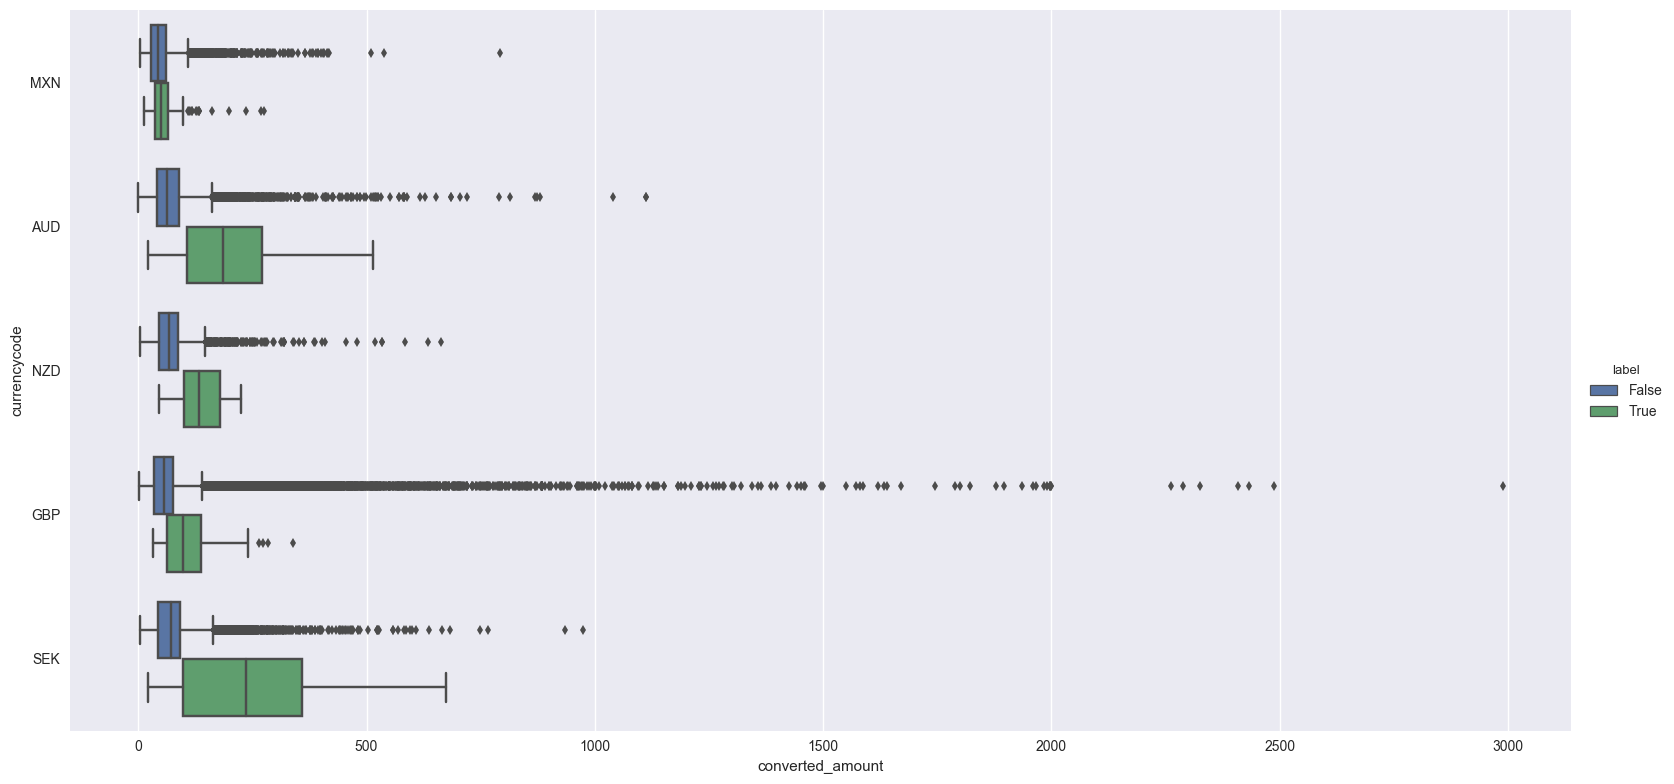

In [75]:
sns.factorplot(data=cleaned_df,x="converted_amount", y="currencycode", hue="label",kind='box',size=8, aspect=2)

* Visualize the cvcresponsecode and converted_amount. As in the piture below, fraud transactions only happenend in "match(1)" and "unknown(1)", while benign transactions covered all the four types of cvcresponsecode. This difference implies that cvcresponsecold is a informative feature.

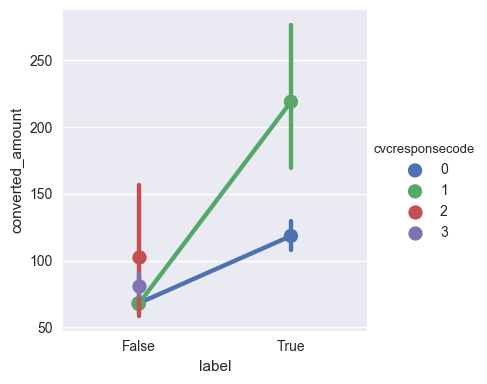

In [440]:
sns.factorplot(data=cleaned_df,x="label", y="converted_amount",hue="cvcresponsecode")

### Step2: Imblance  task
Three classifiers are chosen: Random Forest, Logistic Regression and Supporting Vector Machine.


In [33]:
fraud_df = cleaned_df[cleaned_df['label']==True]
safe_df =  cleaned_df[cleaned_df['label']==False]

In [34]:
#calculate the percentage of fraud
print 'Number of fraud:',len(fraud_df)
print 'Number of safe trasactions:',len(safe_df)
print 'Percentage of fraud:',100.0*len(fraud_df)/len(cleaned_df),'%'

Number of fraud: 345
Number of safe trasactions: 236691
Percentage of fraud: 0.14554751177 %


In [35]:
from utilities import ROC_analysis

In [37]:
from utilities import ROC_analysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

forest = RandomForestClassifier(n_estimators=100, n_jobs=2)
lr = LogisticRegression(C=500, penalty='l1')
nb = GaussianNB()

clf = {}
clf['forest'] = forest
clf['lr'] = lr
clf['NB'] = nb 
fpr, tpr, auc_score = ROC_analysis(clf,X,y,r=0.2)

As shown in the ROC curve, SMOTE shows a better performance in general. In random forest, SMOTE shows a slight improvement, compared with original data. Therefore, we think using SMOTE is a good idea. This is consistent with the content of paper "SMOTE: Synthetic Minority Over-sampling Technique", which indicates that SMOTE is particularly useful for the data that contain both numerical and categorical features.However, One disadvantage is that it creates artificial instances, which can be incorrect/very noisy and even overlap with positive instances.

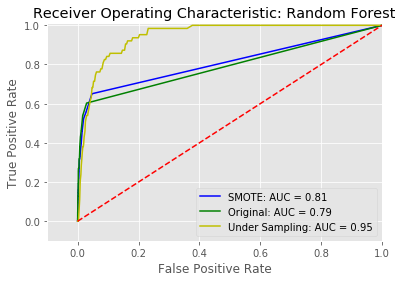

In [38]:
    plt.title('Receiver Operating Characteristic: Random Forest')

    plt.plot(fpr['forest']['SMOTE'], tpr['forest']['SMOTE'], 'b',label='SMOTE: AUC = %0.2f'% auc_score['forest']['SMOTE'])
    plt.plot(fpr['forest']['original'], tpr['forest']['original'], 'g',label='Original: AUC = %0.2f'% auc_score['forest']['original'])
    plt.plot(fpr['forest']['UnderSampling'], tpr['forest']['UnderSampling'], 'y',label='Under Sampling: AUC = %0.2f'% auc_score['forest']['UnderSampling'])

    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

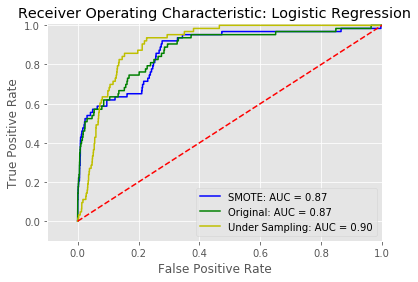

In [39]:
    plt.title('Receiver Operating Characteristic: Logistic Regression')

    plt.plot(fpr['lr']['SMOTE'], tpr['lr']['SMOTE'], 'b',label='SMOTE: AUC = %0.2f'% auc_score['lr']['SMOTE'])
    plt.plot(fpr['lr']['original'], tpr['lr']['original'], 'g',label='Original: AUC = %0.2f'% auc_score['lr']['original'])
    plt.plot(fpr['lr']['UnderSampling'], tpr['lr']['UnderSampling'], 'y',label='Under Sampling: AUC = %0.2f'% auc_score['lr']['UnderSampling'])

    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show()

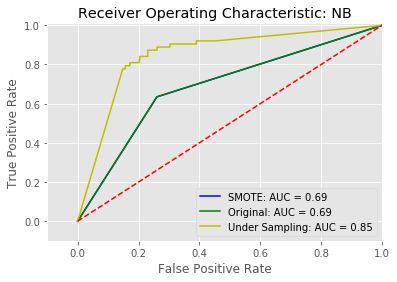

In [40]:
    plt.title('Receiver Operating Characteristic: NB')
    plt.plot(fpr['NB']['SMOTE'], tpr['NB']['SMOTE'], 'b',label='SMOTE: AUC = %0.2f'% auc_score['NB']['SMOTE'])
    plt.plot(fpr['NB']['original'], tpr['NB']['original'], 'g',label='Original: AUC = %0.2f'% auc_score['NB']['original'])
    plt.plot(fpr['NB']['UnderSampling'], tpr['NB']['UnderSampling'], 'y',label='Under Sampling: AUC = %0.2f'% auc_score['NB']['UnderSampling'])

    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Step3: Classification  task

### Preprocessing: 
1. We normalized the numerical variables("amount" and "converted_amunt") to the same scale.Preprocessing.
2. We dropped some features, some of which are not informative, others are associated with "future" information.
3. What's more, we encoded categorical features to numerical, using dense_encoding and pd.get_dummies.
4. We encoded ordinal features.
5. Last, we assigned training data and lables.

In [8]:
# For numerical variables, scale them
from sklearn.preprocessing import StandardScaler
cleaned_df['norm_amount'] = StandardScaler().fit_transform(cleaned_df['amount'].values.reshape(-1, 1))
cleaned_df['norm_converted_amount'] = StandardScaler().fit_transform(cleaned_df['converted_amount'].values.reshape(-1, 1))

In [9]:
# drop features that will not be used
data = cleaned_df.drop(['txid','bookingdate','amount','simple_journal','converted_amount','creation_date','creationdate','card_id','ip_id','mail_id'],axis=1)

 We find that most of "bin" appear rarely,
 so we decided to encode these rare objects to "others", which can significantly reduce the dimension of features.

In [10]:
# Do some statistic, and we find the "long_tail" in the distribution'ip_id'.
print cleaned_df.bin.count() 
sum(cleaned_df.ip_id.value_counts()<=10)

237036


206658

In [11]:
#encode 'bin'.
def dense_encoding(column,threshold):
    count = dict(data[column].value_counts())
    mapping = {}
    for id in count.keys():
        if count[id]>threshold:
            mapping[id] = id
        else:
            mapping[id] = 'others'
    data[column] = data[column].map(mapping)
    
#dense_encoding('ip_id',10)
#dense_encoding('mail_id',10)
dense_encoding('bin',2)

In [12]:
# Encode for ordinal feature: creation day
date_mapping = {label:idx for idx,label in enumerate(data['creation_day'].unique())}
data['creation_day'] = data['creation_day'].map(date_mapping)

In [13]:
# Encode for categorical variables
columns = list(data.columns)
columns.remove('norm_amount')
columns.remove('norm_converted_amount')
columns.remove('label')
columns.remove('creation_day')
encoded_data = pd.get_dummies(data,columns=columns,dummy_na=True)

In [14]:
# Assign traing data to X, label to y
X = encoded_data.ix[:,encoded_data.columns !='label']
y = encoded_data.ix[:,encoded_data.columns =='label'].label

In [15]:
features = X.columns

### Build two classifiers:
1. White box: Logistic Regression
2. Black box: Random Forest



In [16]:
#convert dataframe to array
X=X.values
y=y.values

In [17]:
#reshuffle data
from sklearn.utils import shuffle
X, y = shuffle(X, y)

* First, We define some functions, including parameter tuning and 10-fold cross_validation 

In [18]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.cross_validation import StratifiedKFold
from imblearn.over_sampling import SMOTE

# Function of using traditional 80-20 train-test splitting for parameter tuning(SMOTE ratio and threshold) 
def train_test_split_eval(clf, X=X, y=y):
    # Set some parameters for tuning
    r_list = [0.01, 0.05, 0.1, 0.2]
    prob_threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    best_f = 0
    best_r = 0

    # 80-20 Spliting
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)
    
    # Find best ratio for SMOTE
    for r in r_list:
        smote = SMOTE(ratio= r)
        X_train, y_train = smote.fit_sample(X_train, y_train)
        clf.fit(X_train, y_train)
        y_scores = clf.predict_proba(X_test)[:,1]
        
        better_f = 0
        better_t = 0
        
        # Find best threshold
        for t in prob_threshold:
            y_pred = y_scores > t
            tn, fp, fn, tp = confusion_matrix(y_pred=y_pred,y_true=y_test).ravel()
            precision = 1.0 * tp / (tp + fp)
            recall = 1.0 * tp /(tp + fn)
            # Using F_0.5 score as a metric to choose best threshold
            f = (1 + 0.25)*(precision * recall)/(0.25 *precision + recall)
            if f > better_f:
                better_t = t
                better_f = f
                
        y_pred = y_scores > better_t
        tn, fp, fn, tp = confusion_matrix(y_pred=y_pred,y_true=y_test).ravel()
        precision = 1.0 * tp / (tp + fp)
        recall = 1.0 * tp /(tp + fn)
        f = (1 + 0.25)*(precision * recall)/(0.25 *precision + recall)  
        
        if f > best_f:
            best_r = r
            best_f = f
            best_t = better_t
            best_confusion = (tn, fp, fn, tp)
            best_clf = clf
            
    print 'best f score: ',best_f
    print 'best SMOTE ratio is %f, with threshold %f' %(best_r, best_t)
    return best_confusion, best_clf

C:\Users\Jiang\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
# This is the function for final 10-fold Cross Validation
def ten_fold_CV_eval(clf, X=X, y=y, r=0.05):
    # Create folds
    kfold = StratifiedKFold(y=y,
                            n_folds=10,
                           random_state = 5)
    auc_scores = []
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    fhalfs = []
    smote = SMOTE(ratio= r)
    for k, (train, test) in enumerate(kfold):
        print "Start %d fold:" %k
        
        X_train = X[train]
        y_train = y[train]
        # SMOTE
        X_train, y_train = smote.fit_sample(X_train, y_train)
        print "Finished SMOTE!"
        clf.fit(X_train, y_train)
        del X_train
        
        y_scores = clf.predict_proba(X[test])[:,1]
        y_pred = y_scores > 0.5
        tn, fp, fn, tp = confusion_matrix(y_pred=y_pred,y_true=y[test]).ravel()
        print tn, fp, fn, tp
        recall = float(tp) /(tp+fn)
        try:
            precision = float(tp) / (tp + fp)
            f1 = float(2) * (precision*recall) / (precision+recall)
            fhalf = (1 + 0.25)*(precision * recall)/(0.25 *precision + recall)
        except:
            precision = 0 
            f1 = 0
            fhalf = 0
        accuracy = float(tp+tn)/(tp+tn+fn+fp)
        auc_score = roc_auc_score(y[test], y_scores)
        fpr, tpr, thresholds = roc_curve(y[test],y_scores)
        auc_scores.append(auc_score)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        fhalfs.append(fhalf)
            
    avg_score = np.mean(auc_scores)
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1s)
    avg_fhalf = np.mean(fhalfs)
    #plt_ROC(fpr, tpr, avg_score)
    return avg_score, avg_accuracy, avg_precision, avg_recall, avg_f1, avg_fhalf

#### Logistic regression model
1. Tune the model and find good parameters for this classifier using 80-20 train-test splitting
2. Use the parameters to build a classifer and then explain this model 

In [19]:
# build Random Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=400, penalty='l1')

In [114]:
#Because of the time-consuming implement,we only tune parameters fot logistic regression
(tn, fp, fn, tp) , best_clf = train_test_split_eval(lr)

best f score:  0.136054421769
best SMOTE ratio is 0.010000, with threshold 0.800000


Using logistic model, we can get all the coefficients of features. The feature with larger positive coefficient makes more contribution to assign objects to label"fraud", while the feature with larger negative coefficient makes more contribution to assign objects to label "benign".This is the reason that logistic regression is explainable as a white box algorithm.

In [161]:
# coefficient of all features
best_clf.coef_

array([[-0.0132722 , -0.23963876,  1.41608095, ...,  0.53262985,
        -0.8727644 ,  0.        ]])

In [182]:
# choose the first 40 features and visualize them. We do this for showing an sample of feature coefficient
first_40_coef = best_clf.coef_[:,0:40]
first_40_coef = [c for c in first_40_coef[0]]

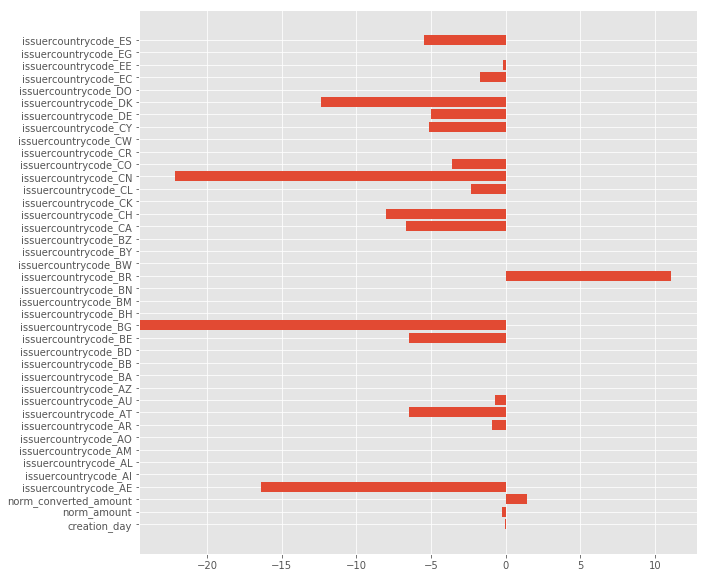

In [192]:
plt.figure(figsize=(10,10))
plt.barh(range(40),first_40_coef)
plt.yticks(range(40),features[0:40],rotation=0)
plt.show()

In [26]:
# Call the cross-validation function and show the result of Logistic Regression
avg_score_1, avg_accuracy_1, avg_precision_1, avg_recall_1, avg_f1_1, avg_fhalf_1 = ten_fold_CV_eval(lr,X,y,0.01)
#In every fold we print tn, fp, fn, tp to see how it works.

Start 0 fold:
Finished SMOTE!
23653 17 28 7
Start 1 fold:
Finished SMOTE!
23650 19 31 4
Start 2 fold:
Finished SMOTE!
23635 34 31 4
Start 3 fold:
Finished SMOTE!
23644 25 30 5
Start 4 fold:
Finished SMOTE!
23628 41 25 10
Start 5 fold:
Finished SMOTE!
23637 32 29 5
Start 6 fold:
Finished SMOTE!
23642 27 31 3
Start 7 fold:
Finished SMOTE!
23654 15 26 8
Start 8 fold:
Finished SMOTE!
23636 33 30 4
Start 9 fold:
Finished SMOTE!
23650 19 31 3


#### Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=400, n_jobs=10)

In [25]:
# Call the cross-validation function and show the result of Random forest
avg_score, avg_accuracy, avg_precision, avg_recall, avg_f1, avg_fhalf = ten_fold_CV_eval(forest,X,y,0.01)
#In every fold we print tn, fp, fn, tp to see how it works.

Start 0 fold:
Finished SMOTE!
23667 3 32 3
Start 1 fold:
Finished SMOTE!
23662 7 30 5
Start 2 fold:
Finished SMOTE!
23665 4 29 6
Start 3 fold:
Finished SMOTE!
23666 3 33 2
Start 4 fold:
Finished SMOTE!
23661 8 28 7
Start 5 fold:
Finished SMOTE!
23667 2 30 4
Start 6 fold:
Finished SMOTE!
23666 3 31 3
Start 7 fold:
Finished SMOTE!
23664 5 29 5
Start 8 fold:
Finished SMOTE!
23664 5 32 2
Start 9 fold:
Finished SMOTE!
23663 6 34 0


### Model comparison
Finally, we compare our two models with respect to:
* auc score
* accuracy
* recall
* precision
* $F_1$ score
* $F_{0.5}$ score

All the scores are obtained through 10-fold cross validation.

In [43]:
#print the results of two model respectively.Loistic Regression(LR), Random Forest(RF). 
print ("average auc score of LR is:%0.3f,    average auc score of RF is:%0.3f" % (avg_score_1,avg_score))
print ("average accuracy of LR is:%0.3f,     average accuracy of RF is%0.3f" % (avg_accuracy_1,avg_accuracy))
print ("average precision of LR is:%0.3f,    average precision of RF is:%0.3f" % (avg_precision_1,avg_precision))
print ("average recall of LR is:%0.3f,       average recall of RF is:%0.3f" % (avg_recall_1,avg_recall))
print ("average F1 score of LR is:%0.3f,     average F1 score of RF is:%0.3f" % (avg_f1_1,avg_f1))
print ("average F0.5 score of LR is:%0.3f,   average F0.5 score of RF is:%0.3f" % (avg_fhalf_1,avg_fhalf))

average auc score of LR is:0.913,    average auc score of RF is:0.890
average accuracy of LR is:0.998,     average accuracy of RF is0.999
average precision of LR is:0.176,    average precision of RF is:0.434
average recall of LR is:0.153,       average recall of RF is:0.107
average F1 score of LR is:0.161,     average F1 score of RF is:0.168
average F0.5 score of LR is:0.169,   average F0.5 score of RF is:0.261


We consider that $F_{0.5}$ score is the most appropriate performance criteria. 

Campared with $F_1$, $F_{0.5}$ score weighs recall lower than precision (by attenuating the influence of false negatives), which is suitable for our scenario (Banks pay more attention to precision than recall because FP is the most unwanted).

Random Forest shows a much higher precision as well as $F_{0.5}$ than that of Logistic Regression.Therefore,we think that Randon Forest gives us the best result ( precision $0.434$, recall $0.107$, $F_{0.5}$ $0.261$ ). 